In [1]:
import xarray as xr
import warnings
warnings.simplefilter('ignore', xr.SerializationWarning)
xr.__version__

'0.11.0'

## Set up Dask Cluster

In [ ]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
client = Client(cluster)
cluster

## Construct Xarray Dataset by Crawling THREDDS Server

We are using NARR daily pressure-level data.

https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.html

In [6]:
from siphon.catalog import TDSCatalog
cat_url = 'https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.xml'
cat = TDSCatalog(cat_url)
dsets = [(cds.remote_access(use_xarray=True)
             .reset_coords(drop=True)
             .chunk({'time': 1, 'level': 5}))
         for cds in cat.datasets[:30]]
narr = xr.auto_combine(dsets)
narr

<xarray.Dataset>
Dimensions:            (level: 29, nbnds: 2, time: 912, x: 349, y: 277)
Coordinates:
  * level              (level) float32 1000.0 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 32463.0 64926.0 ... 8927325.0 8959788.0
  * x                  (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * time               (time) datetime64[ns] 1979-01-01 ... 1981-06-30
Dimensions without coordinates: nbnds
Data variables:
    Lambert_Conformal  (time) int32 -2147483647 -2147483647 ... -2147483647
    time_bnds          (time, nbnds) float64 dask.array<shape=(912, 2), chunksize=(1, 2)>
    air                (time, level, y, x) float32 dask.array<shape=(912, 29, 277, 349), chunksize=(1, 5, 277, 349)>

## Process Data in Parallel

This works amazingly well.

In [7]:
air_mean = narr.air[:100].mean(dim='time').load()

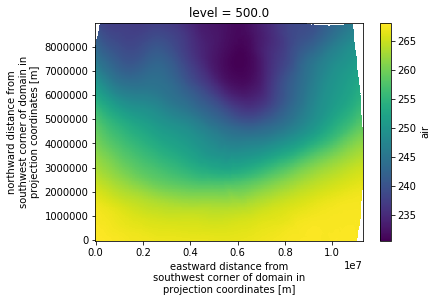

In [9]:
%matplotlib inline
air_mean.sel(level=500).plot()